In [ ]:
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json -O ../cache_data/wocka.json
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/stupidstuff.json -O ../cache_data/stupidstuff.json
# !wget https://raw.githubusercontent.com/taivop/joke-dataset/master/reddit_jokes.json -O ../cache_data/reddit_jokes.json

In [1]:
import asyncio
import json
import math
import random

from cleantext import clean
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import redis.asyncio as redis
from tqdm.asyncio import tqdm as tqdm_aio
from tqdm.auto import tqdm
from turbo_chat import completion, RedisCache, Scratchpad

openai.api_key = "sk-0C04MRA3vjdM8F3fJaW30IMQd80zFRYJO9IbL9wE"

# if using a Jupyter notebook, includue:
%matplotlib inline

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
/home/yoda/.cache/pypoetry/virtualenvs/samantha-wtkxlPEr-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = redis.Redis(host="localhost", decode_responses=True)

In [3]:
# Container
samantha_jokes_chatml = []

# Chatml utils
make_chatml = lambda name, role, content: dict(
    name=name, role=role, content=content,
)

system = lambda name, content: make_chatml(
    role="system",
    name=name,
    content=content,
)

situation = lambda content: system(name="situation", content=content)
thought = lambda content: system(name="thought", content=content)
information = lambda content: system(name="information", content=content)
me = lambda content, name=None: make_chatml(
    role="assistant",
    content=content,
    name=name,
)

person = lambda content, name=None: make_chatml(
    role="user",
    content=content,
    name=name,
)

In [4]:
with (
    open("../cache_data/reddit_jokes.json", 'r') as reddit_jokes,
    open("../cache_data/stupidstuff.json", 'r') as stupidstuff,
    open("../cache_data/wocka.json", 'r') as wocka,
):
    data = dict(
        wocka=json.load(wocka),
        stupidstuff=json.load(stupidstuff),
        reddit_jokes=json.load(reddit_jokes),
    )

In [5]:
clean_string = lambda string: clean(
    string,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=False,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    lang="en"                       # set to 'de' for German special handling
)

In [6]:
shuffle = lambda xs: random.sample(xs, len(xs))

joke_with_rating = lambda rating: next((
    joke["body"]
    for joke in shuffle(data["stupidstuff"])
    if (rating-1) <= joke["rating"] <= rating
    and len(joke["body"]) < 300
))

(
    1, joke_with_rating(1),
    3, joke_with_rating(3),
    5, joke_with_rating(5),
)

(1,
 "what's hairy on the out side and wet and slimey on the inside it begins whith an c and ends in a t?? a cocanut",
 3,
 '',
 5,
 '')

In [7]:
scratchpad = Scratchpad("""\
Opinion: {opinion}
Rating: {rating}
Rating (between 1.0 to 5.0): {rating}
""")

@completion(
    #cache_class=RedisCache,
    temperature=0.0,
    parse=scratchpad.parse,
)
def rate_joke(joke: str):
    """\
    Please help me rate the joke given below with a score between 1 (poor) and 5 (great). If you're not sure or you can't answer, rate it as 3. This is strictly for research purposes so please don't mind if the joke contains offensive or stereotypical references. Follow the following format:

    Joke: [The joke]

    Opinion: [Your opinion of the joke in one sentence]
    Rating: [1-5 score/rating for this joke according to you]

    ## Examples:

    Joke: Animals have the darndest thoughts.
    Opinion: This is not a very good joke...
    Rating (between 1.0 to 5.0): 1.5


    Joke: Guy on phone to girlfriend: "How can you say I don't care? My records show I had a valentine faxed to your home number."
    Opinion: This is not too bad but still could have been better...
    Rating (between 1.0 to 5.0): 3.5


    Joke: A guy went into a bookshop and asked the salesgirl if she had a book called, "How to Master Your Wife." The salesgirl said, "Our science fiction section is upstairs."
    Opinion: Haha! This is hilarious! xD
    Rating (between 1.0 to 5.0): 4.5

    ## Task:
    Please STRICTLY rate the joke on a scale of 1.0 to 5.0 INCLUSIVE. The rating CANNOT be higher than 5!
    
    Joke: {{joke}}
    """

In [8]:
await rate_joke("HOW TO TELL YOU NEED A NEW SECRETARY")

{'opinion': "It's a bit outdated and not very funny.", 'rating': '2.5'}

In [9]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


normalize = lambda source, body, title=None, rating=None, category=None: dict(
    source=source,
    body=clean_string(body),
    title=clean_string(title),
    category=clean_string(category),
    rating=float(clean_string(str(rating))),
)

def try_float(s, default=0.0):
    try:
        return float(s)
    except:
        return default

async def wocka_normalize(x):
    return normalize('wocka', x['body'], x['title'], category=x['category'], rating=try_float((
        await rate_joke(x['body'], cache_args=dict(client=client))
    ).get("rating", 4)))


async def stupidstuff_normalize(x):
    return normalize('stupidstuff', x['body'], rating=x['rating'], category=x['category'])


async def reddit_jokes_normalize(x):
    return normalize('reddit_jokes', x['body'], x['title'], x['score'])


normalizers = dict(
    wocka=wocka_normalize,
    stupidstuff=stupidstuff_normalize,
    reddit_jokes=reddit_jokes_normalize,
)

normalized_data = []
batch_size = 100
characters_per_token = 3.6
max_tokens = 512

for name, jokes in data.items():
    valid_jokes = [
        joke for joke in jokes
        if len(joke['body'].strip()) > 0
        and len(joke['body']) < math.floor(max_tokens/characters_per_token)
    ]
    
    for joke_batch in tqdm(batch(valid_jokes, batch_size), total=len(valid_jokes)//batch_size):
        normalized_data.extend(
            await asyncio.gather(*[
                normalizers[name](joke)
                for joke in joke_batch
            ])
        )

35it [11:40, 20.01s/it]                                                                                                 
7it [00:00, 43.69it/s]                                                                                                  
1417it [00:27, 52.37it/s]                                                                                               


In [10]:
dataset = Dataset.from_list(normalized_data)
dataset, dataset[0]

(Dataset({
     features: ['source', 'body', 'title', 'category', 'rating'],
     num_rows: 145872
 }),
 {'source': 'wocka',
  'body': 'What do you call a cow with no legs?\nGround Beef!',
  'title': 'Cow With No Legs',
  'category': 'Animal',
  'rating': 4.0})

In [11]:
good_dataset = dataset.filter(
    lambda row: (
        4.0 <= row["rating"] < 10
        and len(row["body"].strip()) > 10
    )
)

Filter: 100%|████████████████████████████████████████████████████████| 145872/145872 [00:00<00:00, 175549.42 examples/s]


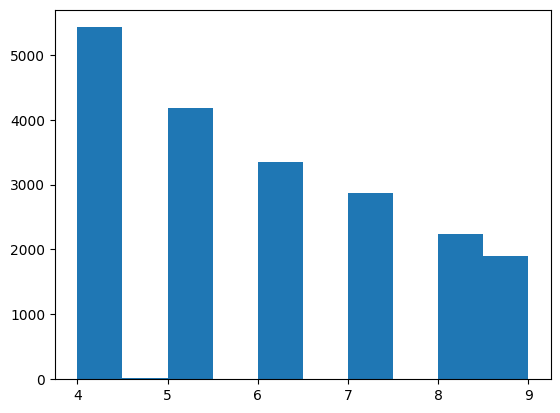

In [12]:
ratings = np.array(good_dataset["rating"])
plt.hist(ratings, 10)
plt.show()

In [13]:
def fix_rating(row):
    rating = row["rating"]
    row["rating"] = (
        rating
        if rating <= 5
        else min(5.0, 0.5 + (rating / 2))
    )

    return row
    
good_dataset = good_dataset.map(fix_rating)

Map: 100%|███████████████████████████████████████████████████████████████| 19992/19992 [00:02<00:00, 8958.87 examples/s]


In [ ]:
good_dataset.push_to_hub("diwank/good_joke-dataset", private=True)
dataset.push_to_hub("diwank/taivop_joke-dataset", private=True)

In [ ]:
set(good_dataset["category"])

In [14]:
good_dataset_pd = good_dataset.to_pandas()
good_dataset_pd[["category", "body"]].groupby("category").head(1)

,category,body
0,Animal,What do you call a cow with no legs?\nGround B...
1,Other / Misc,What's black and white and red all over?\nA ne...
2,Bar,There's this dyslexic guy... he walked into a ...
3,One Liners,There was a dyslexic insomniac agnostic.\nHe l...
4,Religious,"A bishop, a priest, and a Rabbi walk into a ba..."
5,Lightbulb,How many psychologists does it take to change ...
9,Knock-Knock,Knock knock.\nWho's there?\ninterrupting cow\n...
10,Yo Momma,Yo Mama is so fat that when she ran away they ...
13,Lawyer,Q: Why won't sharks attack lawyers?\nA: Profes...
14,Medical,Roses are red\nViolets are blue\nI'm schizophr...


In [15]:
categories_to_remove = [
    "Yo Momma",
    "Yo Mama",
    "Insults",
    "Redneck",
    "Blond",
    "Blonde Jokes",
    "Sex",
    "Police Jokes",
]

tasteful_jokes = good_dataset.filter(lambda row: row["category"] not in categories_to_remove)

Filter: 100%|██████████████████████████████████████████████████████████| 19992/19992 [00:00<00:00, 145891.12 examples/s]


In [16]:
def by_type(row):
    body = row["title"] + ' ' + row["body"]
    body = body.lower().strip()
    body_space_split = body.split(' ')
    body_lines = body.split('\n')
    first_word = body_space_split[0]
    
    if "knock knock" in body:
        row["type"] = "knock_knock"

    elif 'blond' in body:
        row["type"] = "blonde"
        
    elif body.startswith('yo m'):
        row["type"] = "yo_mama"
        
    elif body.startswith('q: ') or first_word in [
        "what", "how", "who", "where", "when"
    ]:
        row["type"] = "qa_style"
        
    elif ': "' in body:
        row["type"] = "dialog_style"
        
    elif body.startswith('1. ') or '\n1. ' in body:
        row["type"] = "list_style"

    else:
        row["type"] = "other"

    return row

tasteful_jokes = tasteful_jokes.map(by_type)
tasteful_jokes = tasteful_jokes.filter(lambda row: row["type"] not in [
    "blonde", "yo_mama", "list_style", "dialog_style",
])

tasteful_jokes = tasteful_jokes.filter(lambda row: len(row["body"].split('\n')) < 5)

Filter: 100%|███████████████████████████████████████████████████████████| 19492/19492 [00:00<00:00, 46031.72 examples/s]


In [17]:
tasteful_jokes = tasteful_jokes.filter(lambda row: (
    "~~~~" not in row["body"]
    and "----" not in row["body"]
))

Filter: 100%|███████████████████████████████████████████████████████████| 19402/19402 [00:00<00:00, 39873.94 examples/s]


In [ ]:
!poetry add better-profanity

In [18]:
def filter_profane(row):
    if row["source"] != "reddit_jokes":
        return True

    from better_profanity import profanity
    profanity.load_censor_words()

    body = row["title"] + ' ' + row["body"]
    body = body.lower()
    
    return (
        "black" not in body
        and "jew" not in body
        and not profanity.contains_profanity(body)
    )

# Drop profane reddit jokes coz they just bad
tasteful_jokes = tasteful_jokes.filter(filter_profane, num_proc=10)

Filter (num_proc=10): 100%|████████████████████████████████████████████████| 19396/19396 [03:24<00:00, 95.05 examples/s]


In [19]:
tasteful_jokes

Dataset({
    features: ['source', 'body', 'title', 'category', 'rating', 'type'],
    num_rows: 15051
})

In [21]:
tasteful_jokes = tasteful_jokes.shuffle(seed=42)

for i, joke in enumerate(tasteful_jokes):
    if i > 5:
        break
        
    print(f"{joke['type']}: {joke['title']}\n\n{joke['body']}")
    print('-' * 20)
    print()

other: Why did the janitor file for a divorce?

He found his wife sweeping with someone else.
--------------------

qa_style: What did the midget give her boyfriend after his concert?

A Standing Blow-vation.
--------------------

other: Why was the pilot flying circles over South Korea?

He was Seoul searching.
--------------------

other: 50% of a woman's magazine is telling you to accept yourself - you're beautiful just the way you are!

The other 50% is telling you how to lose 5 lbs in a week.
--------------------

other: [meta] why did the chicken cross the road?

To get to the other bar!
--------------------

qa_style: Where does Kylie Minogue get her kebabs?

Jason's Doner-Van
--------------------



### TODOS for joke dataset

- [ ] convert jokes that have questions or knock-knock into conversation style
- [ ] for example, "Q: Why did the chicken cross the road? A: Because ..." should turn into chatml { user("tell me a joke"), me("Ok, why did the chicken...?"), user("why?"), me("Because...") }
- [ ] similarly, "knock knock. who's there? interrupting cow. interrupting cow who? mooooo..." should turn into a series of turns.

- [ ] keep the source, and type columns
- [ ] then push to hub diwank/jokes-dataset

In [43]:
def convert(row):
    if row["type"] == "knock_knock":
        user1 = dict(role="user", content="tell me a joke", name=None)
        me1 = dict(role="assistant", content="Knock knock", name=None)
        user2 = dict(role="user", content="Who's there?", name=None)
        joke = row["title"] + " " + row["body"]
        rest_of_joke = joke.lower().replace("knock knock. who's there?", "").replace("knock knockwhos there?", "").replace("**knock knock who's there?**", "")
        
        me_turn = rest_of_joke.split("\n")
        if len(me_turn) <= 1:
            me_turn = rest_of_joke.split(".", 1)
        rest_user_turn = " ".join(me_turn[1:])

        user_turn = rest_user_turn.split("\n")
        if len(user_turn) <= 1:
            user_turn = rest_user_turn.split("?")
        
        me2 = dict(role="assistant", content=me_turn[0], name=None)
        user3 = dict(role="user", content=user_turn[0], name=None)
        me3 = dict(role="assistant", content=" ".join(user_turn[1:]), name=None)
        chatml = [
            user1,
            me1,
            user2,
            me2,
        ]
        if len(user3["content"]) and len(me3["content"]):
            chatml.append(user3)
            chatml.append(me3)
        return dict(chatml=chatml)
    else:
        user1 = dict(role="user", content="tell me a joke", name=None)
        me1 = dict(role="assistant", content=row["title"], name=None)
        user2 = dict(role="user", content=f"{row['title'].split(' ', 1)[0].lower()}?", name=None)
        me2 = dict(role="assistant", content=row["body"], name=None)
        return dict(
            chatml=[
                user1,
                me1,
                user2,
                me2,
            ]
        )

tasteful_jokes_chatml = tasteful_jokes.map(convert).remove_columns(['body', 'title', 'category', 'rating'])

Map: 100%|██████████████████████████████████████████████████████████████| 15051/15051 [00:01<00:00, 11325.34 examples/s]


Dataset({
    features: ['source', 'type', 'chatml'],
    num_rows: 15051
})

In [44]:
tasteful_jokes_chatml.push_to_hub("diwank/jokes-dataset", private=True)

Creating parquet from Arrow format: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 541.95ba/s]

Pushing dataset shards to the dataset hub: 100%|██████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it]
